IMPORT RELEVANT LIBRARIES

In [42]:
# Settings
import warnings
import pickle
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Machine Learning
from sklearn.model_selection import cross_val_score, StratifiedKFold
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split

# Advanced ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.simplefilter(action="ignore", category=FutureWarning)

PREPARE DATA

IMPORT

In [2]:
def wrangle(filename):
    # Load data
    df = pd.read_csv(filename)
    
    # Drop column Timestamp column
    df = df.drop(columns=["Timestamp"])
    
    # Create Binary Target column
    df['First Class'] = (df['Class'] == 'First class (4.5 -5.0)').astype(int)
    
    # Drop original Class column to avoid data leakage.
    df = df.drop(columns=["Class"])

    #Convert "other activities" column to an int
    df['Other activities'] = (df['Other activities'] == 'Yes').astype(int)
    
    # --- Simple Feature Engineering ---
    # Study efficiency ratio
    df['Study_Efficiency'] = df['Exam preparation'] / (df['Study length'] + 1e-6)
    
    # Activity balance score
    df['Activity_Balance'] = df['Time in activities'] / (df['Study length'] + df['Time in activities'] + 1e-6)
    
    # High attendance flag
    df['High_Attendance'] = (df['Attendance'] >= 4).astype(int)
    
    return df

In [3]:
df = wrangle("/kaggle/input/student-performance-analysis-edited/Student Performance Analysis_ed.csv")

INSPECT DATAFRAME

In [4]:
# Check the shape and head of the DataFrame
print(df.shape)
df.head()

(215, 13)


,Level,Department,Courses written,Total unit load,Attendance,Study length,Exam preparation,Other activities,Time in activities,First Class,Study_Efficiency,Activity_Balance,High_Attendance
0,3rd Year,Biochemistry,57,123,4,3,3,1,3,0,1.000000,0.500,1
1,1st Year,Computer science,18,39,5,5,3,1,5,1,0.600000,0.500,1
2,2nd Year,Statistics,30,60,2,3,1,1,5,0,0.333333,0.625,0
3,1st Year,Computer science,18,39,4,4,5,0,1,1,1.250000,0.200,1
4,3rd Year,Biochemistry,57,123,2,3,2,1,3,0,0.666666,0.500,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Level               215 non-null    object 
 1   Department          215 non-null    object 
 2   Courses written     215 non-null    int64  
 3   Total unit load     215 non-null    int64  
 4   Attendance          215 non-null    int64  
 5   Study length        215 non-null    int64  
 6   Exam preparation    215 non-null    int64  
 7   Other activities    215 non-null    int64  
 8   Time in activities  215 non-null    int64  
 9   First Class         215 non-null    int64  
 10  Study_Efficiency    215 non-null    float64
 11  Activity_Balance    215 non-null    float64
 12  High_Attendance     215 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 22.0+ KB


EXPLORE

Class Distribution

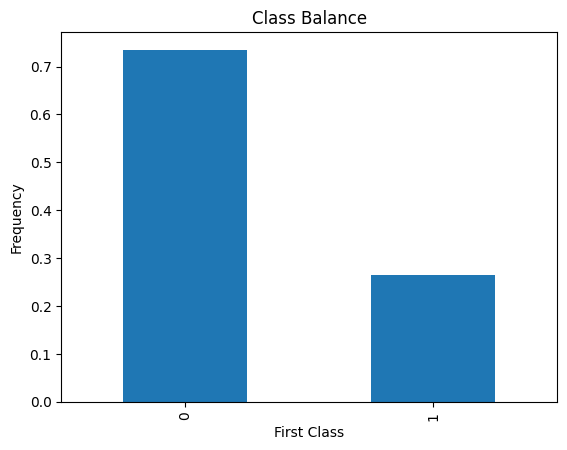

In [6]:
# Plot class balance
df["First Class"].value_counts(normalize=True).plot(
    kind="bar", xlabel="First Class", ylabel="Frequency", title="Class Balance"
);

In [7]:
majority_class_prop, minority_class_prop = df["First Class"].value_counts(normalize = True) 
print("Majority class proportion: ", majority_class_prop, "\nMinority class proportion: ", minority_class_prop)

Majority class proportion:  0.7348837209302326 
Minority class proportion:  0.2651162790697674


Conclusion: From the above visualization and proportion distribution ratio, it is seen that there is class imbalance in the target class and this could bias in model prediction towards the majority class, so we would be handling this using Class weighting technique.

SPLIT

In [8]:
target = "First Class"
X = df.drop(columns=target)
y = df[target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42

)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (172, 12)
y_train shape: (172,)
X_test shape: (43, 12)
y_test shape: (43,)


BUILD MODELS

BASELINE MODEL

In [10]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy: ", round((acc_baseline * 100), 1))

Baseline Accuracy:  74.4


LOGISTIC REGRESSION

In [11]:
model_lr = make_pipeline (
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(class_weight='balanced',
                     max_iter=1000,
                     solver='saga',
                     random_state=42,          
                        n_jobs=-1),
    
)

# Fit model to training data
model_lr.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Level', 'Department'],
                               use_cat_names=True)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [12]:
# Evaluate  logistic regression Model
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
acc_test = model_lr.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.79
Test Accuracy: 0.77


DECISION TREE

In [13]:
#Build Decision Tree Model
model_dt =  make_pipeline (
    OneHotEncoder(use_cat_names=True),DecisionTreeClassifier(max_depth = 6, random_state=42))

# Fit model to training data
model_dt.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Level', 'Department'],
                               use_cat_names=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

In [14]:
# Evaluate  Decision Tree Model
acc_train = accuracy_score(y_train, model_dt.predict(X_train))
acc_test = model_dt.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.94
Test Accuracy: 0.79


RANDOM FOREST CLASSIFIER

In [15]:
#Build Random Forest Model
clf = RandomForestClassifier(random_state=42)

params = {
    "n_estimators": range(25, 100, 25),  
    "max_depth": range(10, 50, 10)       
}

model_rf = make_pipeline (
    OneHotEncoder(use_cat_names=True),GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
))
model_rf

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': range(10, 50, 10),
                                          'n_estimators': range(25, 100, 25)},
                              verbose=1))])

In [16]:
# Train  random forest model
model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Level', 'Department'],
                               use_cat_names=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': range(10, 50, 10),
                                          'n_estimators': range(25, 100, 25)},
                              verbose=1))])

In [17]:
# Evaluate  Random Forest Model
acc_train = accuracy_score(y_train, model_rf.predict(X_train))
acc_test = model_rf.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.97
Test Accuracy: 0.79


GRADIENT BOOSTING CLASSIFIER

In [18]:
#Build Gradient Boosting Model
clf =  GradientBoostingClassifier()

params = {
    "n_estimators": range(20, 31, 5),  
    "max_depth": range(2, 5)       
}

model_GB =make_pipeline (
    OneHotEncoder(use_cat_names=True), GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
))
model_GB

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                              n_jobs=-1,
                              param_grid={'max_depth': range(2, 5),
                                          'n_estimators': range(20, 31, 5)},
                              verbose=1))])

In [19]:
#Train Gradient Boosting Model 
model_GB.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Level', 'Department'],
                               use_cat_names=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                              n_jobs=-1,
                              param_grid={'max_depth': range(2, 5),
                                          'n_estimators': range(20, 31, 5)},
                              verbose=1))])

In [20]:
# Evaluate  Gradient Boosting Model
acc_train = accuracy_score(y_train, model_GB.predict(X_train))
acc_test = model_GB.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.97
Test Accuracy: 0.79


ADVANCED MODELS

XTREME GRADIENT BOOSTING CLASSIFIER

In [21]:
# Calculate class weights
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos  # For XGBoost

#  Build Model XGBoost with class weighting
model_XGB = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    XGBClassifier(
        max_depth=6,
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight,  # Class weighting
        eval_metric='logloss'
    )
)
model_XGB.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Level', 'Department'],
                               use_cat_names=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [22]:
# Evaluate Xtreme Gradient Boosting Model
acc_train = accuracy_score(y_train, model_XGB.predict(X_train))
acc_test = model_XGB.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 1.0
Test Accuracy: 0.81


CATBOOST CLASSIFIER

In [26]:

# Build CATBOOST Model 
model_CAT = CatBoostClassifier(
    max_depth=6,
    random_state=42,
    n_estimators=400,
    learning_rate=0.05,
    verbose=False,
    cat_features=['Level', 'Department'],  
    auto_class_weights='Balanced'         
)

# Fit model to training data (no pipeline needed)
model_CAT.fit(X_train, y_train)

     

In [27]:
# Evaluate CATBOOST Model
acc_train = accuracy_score(y_train, model_CAT.predict(X_train))
acc_test = model_CAT.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.99
Test Accuracy: 0.79


LIGHTGBM MODEL

In [24]:
# Calculate class weights
neg, pos = np.bincount(y_train)
class_weights = {0: 1, 1: scale_pos_weight}  


# LightGBM with similar structure
model_LGBM = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LGBMClassifier(
        max_depth=6,
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        class_weight=class_weights,  # Class weighting
        objective='binary'
    )
)
model_LGBM.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44, number of negative: 128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Level', 'Department'],
                               use_cat_names=True)),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight={0: 1, 1: 2.909090909090909},
                                learning_rate=0.05, max_depth=6,
                                n_estimators=400, objective='binary',
                                random_state=42))])

In [25]:
# Evaluate Light Gradient Boosting Model
acc_train = accuracy_score(y_train, model_LGBM.predict(X_train))
acc_test = model_LGBM.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.99
Test Accuracy: 0.79


FINAL MODEL SELECTION : After training numerous Models, the evaluation metrics show that most of the advanced models overfit the data either because of the small dataset size or the nature/complexity of the model's algorithm. With that said our Final Model will be our Logistic Regression model with a test accuracy of 77% which beat our baseline model by 2.6%.

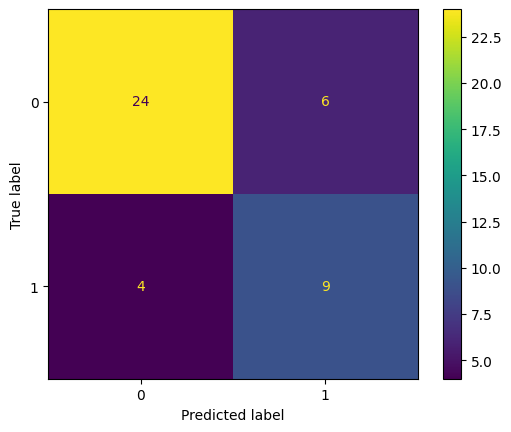

In [38]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test);

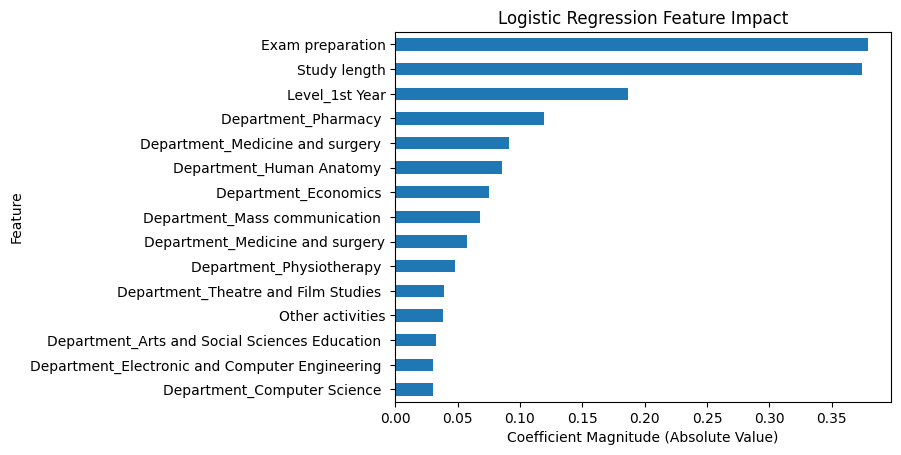

In [41]:
# Get coefficients (logistic regression uses coefficients, not feature_importances_)
importances = model_lr.named_steps["logisticregression"].coef_[0]

# Get transformed feature names from OneHotEncoder
features = model_lr.named_steps["onehotencoder"].get_feature_names_out()

# Create feature importance series
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot top 15 features (using absolute value for importance magnitude)
feat_imp.abs().head(15).sort_values().plot(kind="barh")
plt.xlabel("Coefficient Magnitude (Absolute Value)")
plt.ylabel("Feature")
plt.title("Logistic Regression Feature Impact");

SAVE MODEL TO FILE

In [45]:
#Save model as "final model"
with open("model-LR.pkl", "wb") as final_model:
    pickle.dump(model_lr, final_model)

In [44]:
#Load "final model"
with open("model-LR.pkl", "rb") as final_model:
    loaded_model = pickle.load(final_model)
print(loaded_model)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Level', 'Department'],
                               use_cat_names=True)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])
